### Importing Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

### Data Collection

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)

# Download stock data
ticker_symbol = 'GOOGL'
ticker_data = yf.Ticker(ticker_symbol)
df = ticker_data.history(period='1d', start='2015-11-01', end='2023-11-25')
df.reset_index(inplace=True)
df = df[['Date', 'Close']]
df

,Date,Close
0,2015-11-02 00:00:00-05:00,37.387001
1,2015-11-03 00:00:00-05:00,37.441002
2,2015-11-04 00:00:00-05:00,37.765499
3,2015-11-05 00:00:00-05:00,38.033501
4,2015-11-06 00:00:00-05:00,38.080002
...,...,...
2025,2023-11-17 00:00:00-05:00,135.309998
2026,2023-11-20 00:00:00-05:00,136.250000
2027,2023-11-21 00:00:00-05:00,136.970001
2028,2023-11-22 00:00:00-05:00,138.490005


### Data Preprocessing

In [3]:
# Data is scaled to values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
training_data_len = int(np.ceil(len(df) * 0.8))
scaler.fit(df['Close'].values[:training_data_len].reshape(-1, 1))
scaled_data = scaler.transform(df['Close'].values.reshape(-1, 1))

In [4]:
# Create the training and testing data set
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]

In [5]:
# Split the data into x_train, y_train, x_test, and y_test data sets
x_train, y_train = [], []
x_test, y_test = [], df['Close'][training_data_len:].values

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [6]:
# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

### Build the XGBoost Model

In [7]:
# Build the XGBoost Model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)

# Train the model
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Evaluate the Model and Print RMSE

In [8]:
# Evaluate the Model and Print RMSE
train_predictions = model.predict(x_train)
test_predictions = model.predict(x_test)

# Rescale predictions back to original scale
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))

In [9]:
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 76.61558466082015, Test RMSE: 9.643399387310183


### Visualize the Training Data and Predictions

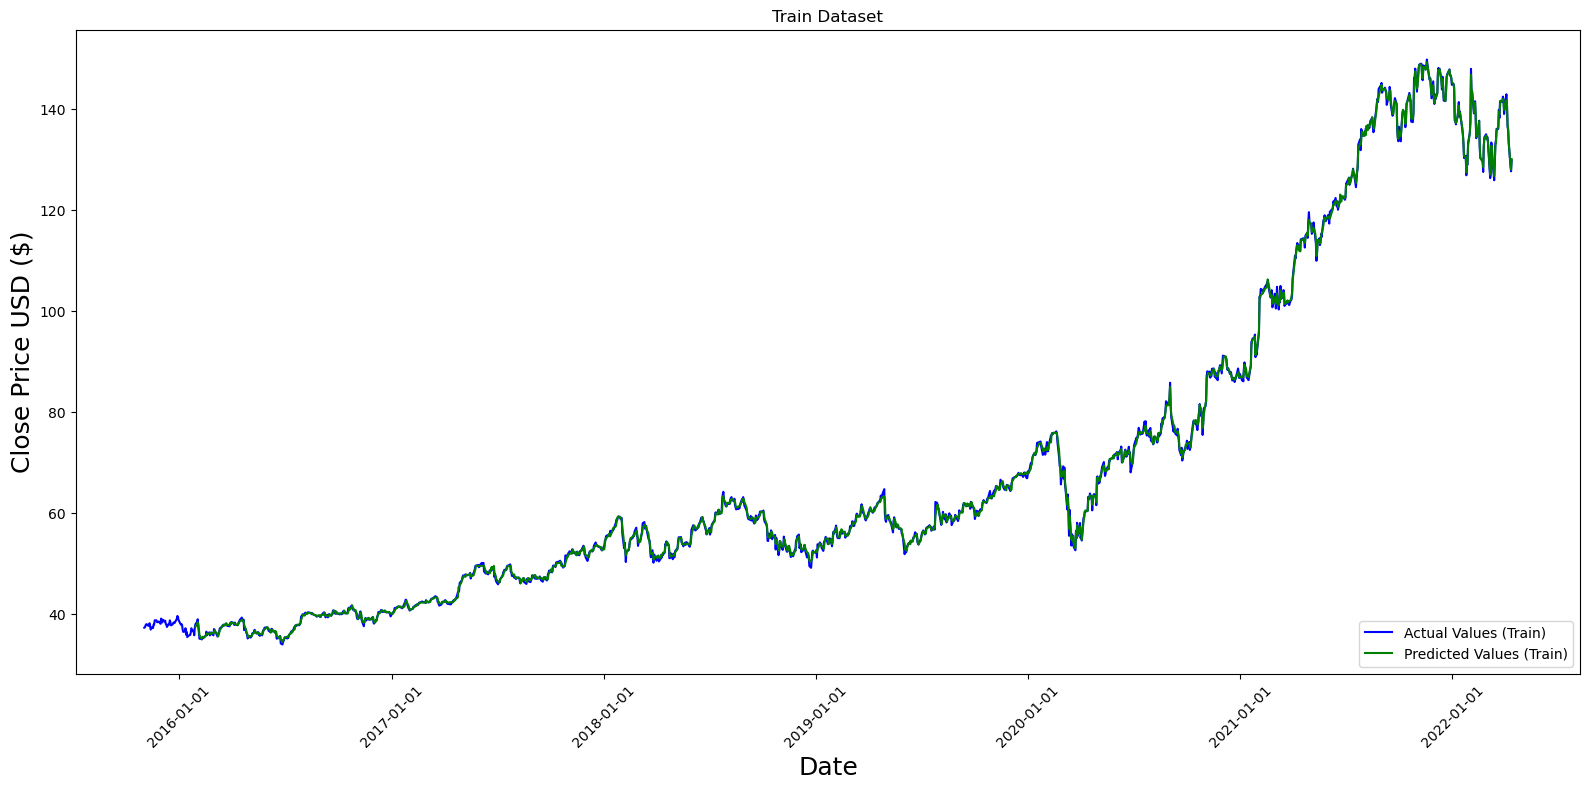

In [10]:
# Visualize the training data and predictions
df['Date'] = pd.to_datetime(df['Date'])
adjusted_train_dates = df['Date'][60:training_data_len]

plt.figure(figsize=(16, 8))
plt.title('Train Dataset')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(df['Date'][:training_data_len], df['Close'][:training_data_len], label='Actual Values (Train)', color='blue')
plt.plot(adjusted_train_dates, train_predictions, label='Predicted Values (Train)', color='green')

plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### Forecasting the Next 365 Days

In [11]:
# Forecast the next 365 days
last_60_days = scaled_data[-60:]
predicted_prices = []

for i in range(365):
    # Correctly reshape the input to 2D array
    X_pred_scaled = last_60_days.reshape(1, -1)
    pred_price_scaled = model.predict(X_pred_scaled)
    predicted_price = pred_price_scaled[0]
    predicted_prices.append(predicted_price)
    # Update last_60_days
    last_60_days = np.append(last_60_days, [[predicted_price]], axis=0)[1:]

predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

last_date = pd.to_datetime(df['Date'].iloc[-1])
prediction_dates = [last_date + pd.Timedelta(days=x + 1) for x in range(365)]
predicted_prices = predicted_prices.flatten()

for i in range(len(prediction_dates)):
    print(f"Predicted closing price for {prediction_dates[i].date()}: ${predicted_prices[i]:.2f}")

Predicted closing price for 2023-11-25: $137.57
Predicted closing price for 2023-11-26: $138.97
Predicted closing price for 2023-11-27: $139.51
Predicted closing price for 2023-11-28: $140.61
Predicted closing price for 2023-11-29: $140.29
Predicted closing price for 2023-11-30: $140.64
Predicted closing price for 2023-12-01: $139.88
Predicted closing price for 2023-12-02: $139.71
Predicted closing price for 2023-12-03: $139.78
Predicted closing price for 2023-12-04: $141.53
Predicted closing price for 2023-12-05: $141.90
Predicted closing price for 2023-12-06: $141.35
Predicted closing price for 2023-12-07: $141.51
Predicted closing price for 2023-12-08: $141.46
Predicted closing price for 2023-12-09: $141.75
Predicted closing price for 2023-12-10: $141.83
Predicted closing price for 2023-12-11: $141.41
Predicted closing price for 2023-12-12: $142.52
Predicted closing price for 2023-12-13: $143.25
Predicted closing price for 2023-12-14: $144.04
Predicted closing price for 2023-12-15: 

### Visualize the Test Data and 365-Day Forecast

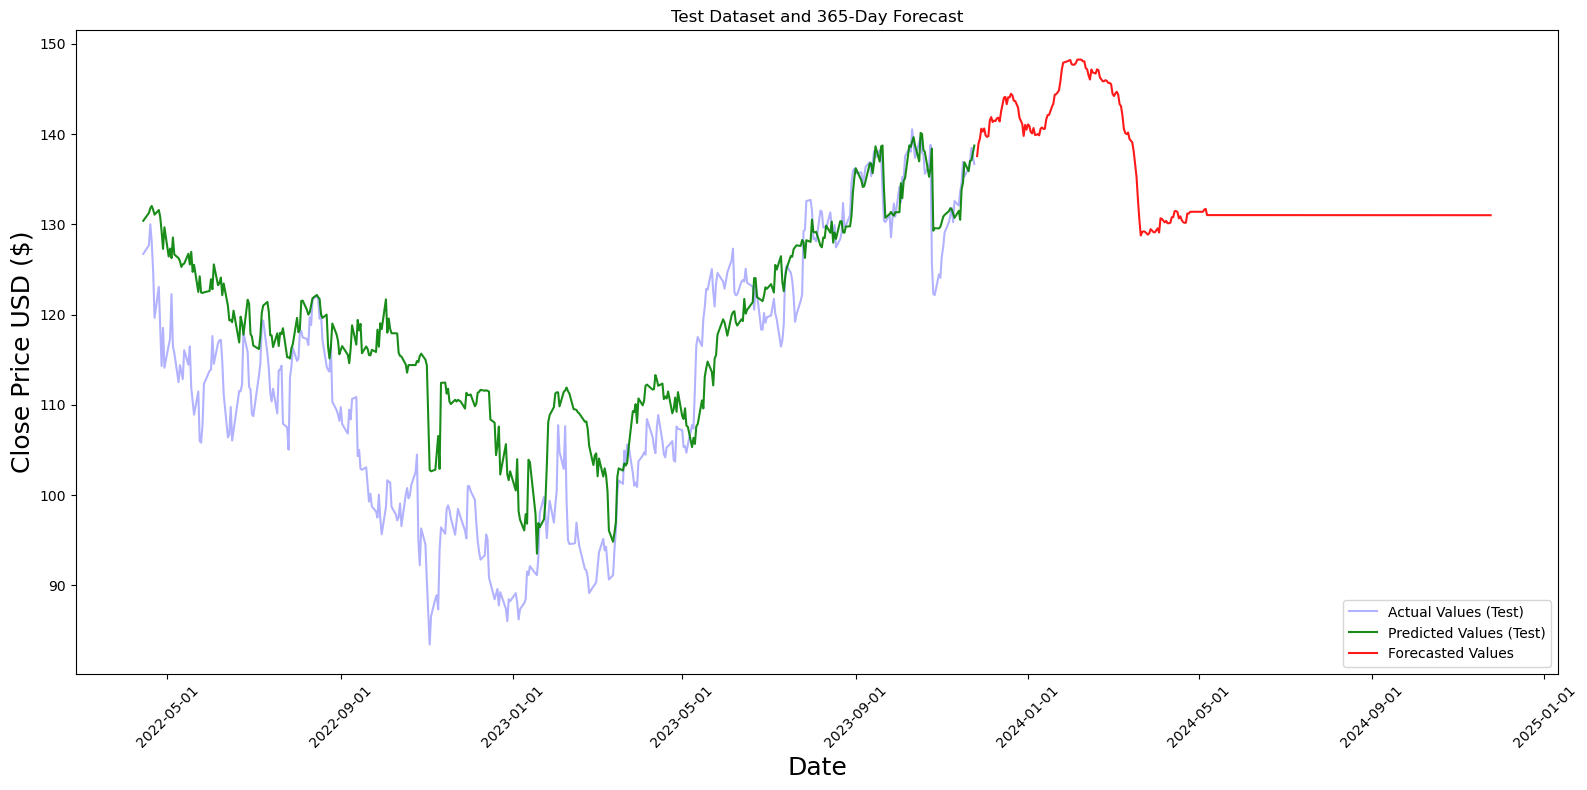

In [12]:
# Prepare the dates for forecasting by extending the existing dates array
forecast_dates = [df['Date'].iloc[-1] + pd.Timedelta(days=x + 1) for x in range(1, 366)]

plt.figure(figsize=(16, 8))
plt.title('Test Dataset and 365-Day Forecast')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(df['Date'][training_data_len:], y_test, label='Actual Values (Test)', color='Blue', alpha=0.3)
plt.plot(df['Date'][training_data_len:], test_predictions, label='Predicted Values (Test)', color='green', alpha=0.9)
plt.plot(forecast_dates, predicted_prices, label='Forecasted Values', color='red', alpha=0.9)

plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()